# D(St)reams of Anomalies

## The real world does not slow down for bad data

#### Author: Ruturaj Kiran Vaidya

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.svm import OneClassSVM

### Data import

<p>For this project, I used nyc taxi data.</p>

<p>Data Link: <a>https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv</a></p>

<p>Five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm</p>

<p>Ref: <a>https://github.com/numenta/NAB/tree/master/data</a></p>

In [2]:
taxi = pd.read_csv("../data/external/nyc_taxi.csv")

In [3]:
taxi.tail()

,timestamp,value
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591
10319,2015-01-31 23:30:00,26288


In [4]:
taxi.shape

(10320, 2)

In [5]:
# Check if there are any NAN values
taxi.dropna().shape

(10320, 2)

In [6]:
# Lets convert timestamp column to index in datetime format
# So, that it will be easier to plot
taxidt = pd.DataFrame(columns=["value"])
taxi["timestamp"] = pd.to_datetime(taxi["timestamp"])
taxidt = taxi.set_index("timestamp")

In [7]:
taxidt.tail()

,value
timestamp,
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309
2015-01-31 23:00:00,26591
2015-01-31 23:30:00,26288


### Visualization of input data and outliers

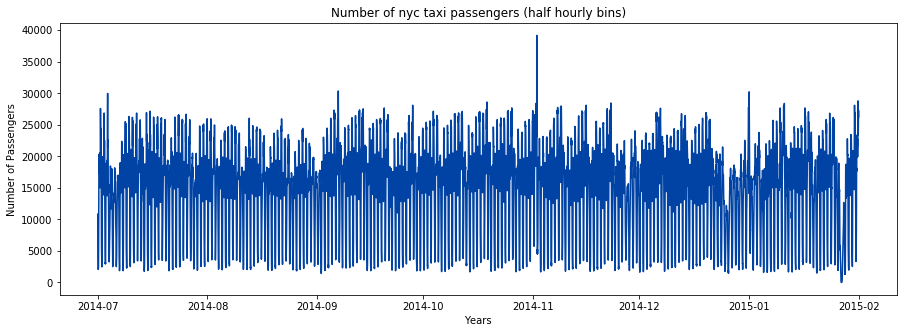

In [8]:
# Plotting

pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(15, 5))
plt.plot(taxidt, color="#0043A4")
plt.title("Number of nyc taxi passengers (half hourly bins)")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.show();

<p>The data consist of - aggregation of the total number of taxi passengers into 30 minute buckets</p>
<p>We can sum up the data into daily bins</p>
<p>As we already know that anomalies are present daily/ seasonally.</p>

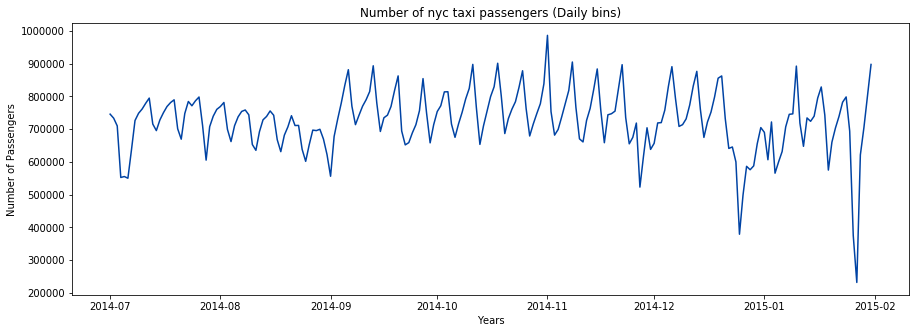

In [9]:
taxidt_daily = taxidt.resample("D").sum()

# Plotting
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(15, 5))
plt.plot(taxidt_daily, color="#0043A4")
plt.title("Number of nyc taxi passengers (Daily bins)")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.show();

There are a couple of methods we can use to visualize the <b>outliers</b>:
<ul>
<li><b>Z Score</b></li>
<li>Interquartile range</li>
</ul>

<p>We will look at the <b>Z Score</b> method</p>
<p>Z Score formula: <b>z=(X - μ)/σ</b></p>

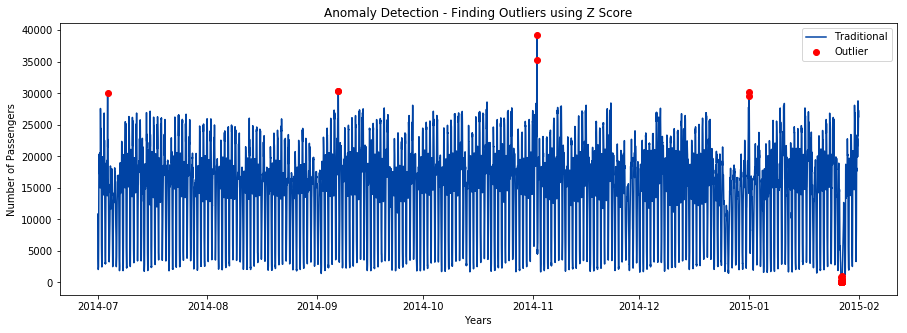

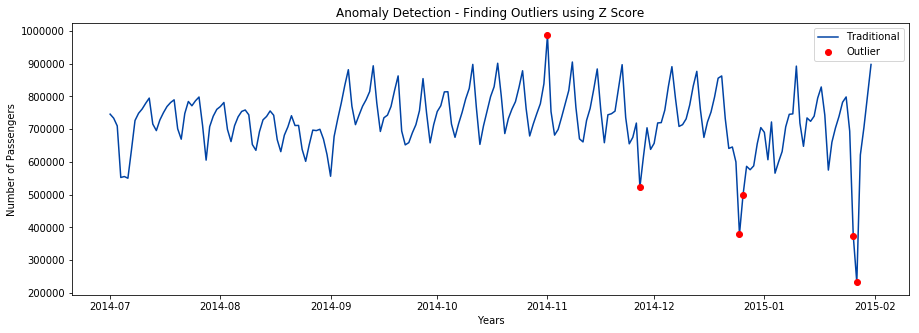

In [10]:
# Z Score: z=(X - μ)/σ
def outlier_z(data):
    threshold = 2
    outliers = pd.DataFrame(columns=["value"])
    m = np.mean(data.value)
    s = np.std(data.value)
    for i,r in data.iterrows():
        z_score = (r.value - m)/s
        if np.abs(z_score) > threshold:
            outliers.at[i,"value"] = r.value
    return outliers

outliers = outlier_z(taxidt)
        
# Plotting
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(15, 5))
plt.plot(taxidt, color="#0043A4", label="Traditional")
plt.plot_date(outliers.index, outliers, color="r", label="Outlier")
plt.title("Anomaly Detection - Finding Outliers using Z Score")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.legend(loc="best")
plt.show();

outliers = outlier_z(taxidt_daily)
        
# Plotting
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(15, 5))
plt.plot(taxidt_daily, color="#0043A4", label="Traditional")
plt.plot_date(outliers.index, outliers, color="r", label="Outlier")
plt.title("Anomaly Detection - Finding Outliers using Z Score")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.legend(loc="best")
plt.show();

How simple and perfect is this z score outlier detection method!

### Modelling

### Isolation Forest

In [11]:
%%capture
taxi["dayofweek"] = taxi["timestamp"].dt.dayofweek
min_max_scaler = preprocessing.StandardScaler()

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(taxi[["value", "dayofweek"]])

model = IsolationForest(contamination=0.01, behaviour="new", random_state=1).fit(pd.DataFrame(np_scaled))

anomaly = pd.Series(model.predict(pd.DataFrame(np_scaled)))
anomaly = anomaly.map( {1: 0, -1: 1} )

a = taxi.loc[anomaly == 1, ["timestamp", "value"]] #anomaly

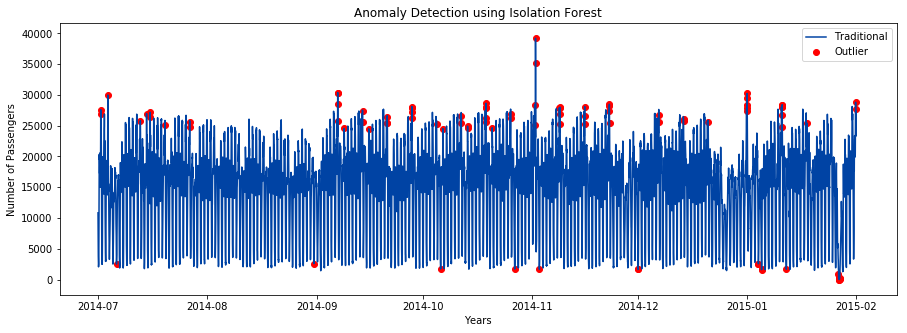

In [12]:
# Anomaly Visualisation using isolation forest

plt.figure(figsize=(15, 5))
plt.plot(taxi.timestamp, taxi.value, color="#0043A4", label="Traditional")
plt.scatter(a.timestamp, a.value, color="r", label="Outlier")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.title("Anomaly Detection using Isolation Forest")
plt.grid(False)
plt.legend(loc="best")
plt.show()

In [13]:
%%capture
taxi_daily = pd.DataFrame(columns=["value"])
taxi_daily["timestamp"] = taxidt_daily.index
taxi_daily["value"] = taxidt_daily["value"].values
taxi_daily["dayofweek"] = taxi_daily["timestamp"].dt.dayofweek

min_max_scaler = preprocessing.StandardScaler()

np_scaled = min_max_scaler.fit_transform(taxi_daily[["value", "dayofweek"]])

model = IsolationForest(contamination=0.01, behaviour="new", random_state=1).fit(pd.DataFrame(np_scaled))

anomaly = pd.Series(model.predict(pd.DataFrame(np_scaled)))
anomaly = anomaly.map( {1: 0, -1: 1} )
a = taxi_daily.loc[anomaly == 1, ["timestamp", "value"]]

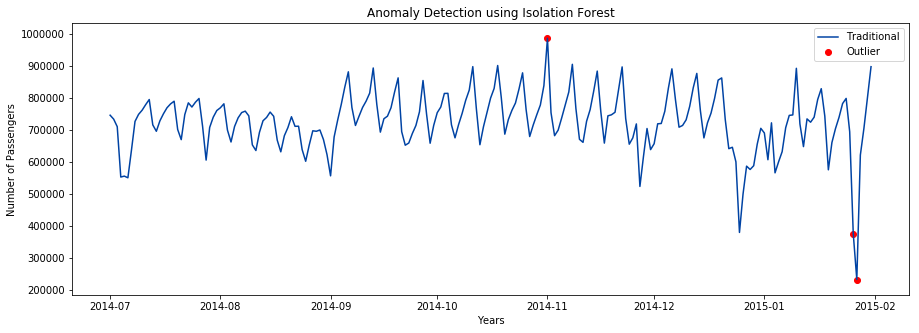

In [14]:
# Anomaly Visualisation using isolation forest
plt.figure(figsize=(15, 5))
plt.plot(taxi_daily.timestamp, taxidt_daily.value, color="#0043A4", label="Traditional")
plt.scatter(a.timestamp, a.value, color="r", label="Outlier")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.title("Anomaly Detection using Isolation Forest")
plt.grid(False)
plt.legend(loc="best")
plt.show()

I observed from isolation forest algorithm is that, it could work better, if the number of features would be more,
or the data is high dimentional. I observed that based on literature I read online.

### One Class Support Vector Machine

In [15]:
%%capture
data = taxi[['timestamp', "value", "dayofweek"]]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[["value", "dayofweek"]])
model =  OneClassSVM(nu=0.95 * 0.01).fit(pd.DataFrame(np_scaled))

data['anomaly'] = pd.Series(model.predict(pd.DataFrame(np_scaled)))
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})

a = data.loc[data['anomaly'] == 1, ['timestamp', 'value']]

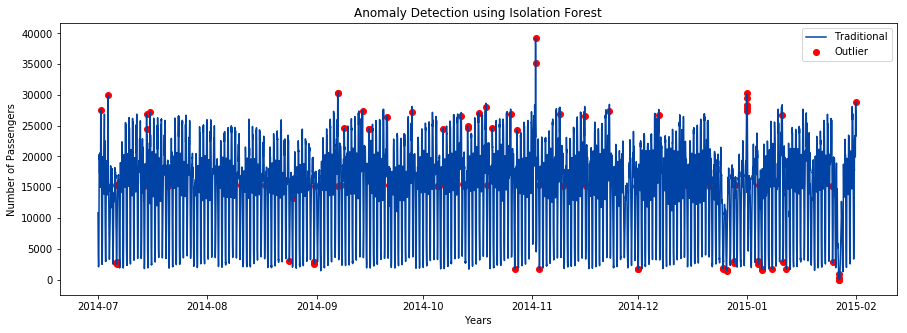

In [16]:
# Anomaly Visualisation using isolation forest
plt.figure(figsize=(15, 5))
plt.title("Anomaly Detection using OneClassSVM")
plt.plot(taxi.timestamp, taxi.value, color="#0043A4", label="Traditional")
plt.scatter(a.timestamp, a.value, color="r", label="Outlier")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.legend(loc="best")
plt.show()

In [17]:
%%capture
data = taxi_daily[['timestamp', "value", "dayofweek"]]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[["value", "dayofweek"]])
model =  OneClassSVM(nu=0.95 * 0.01).fit(pd.DataFrame(np_scaled))

data['anomaly'] = pd.Series(model.predict(pd.DataFrame(np_scaled)))
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})

a = data.loc[data['anomaly'] == 1, ['timestamp', 'value']]

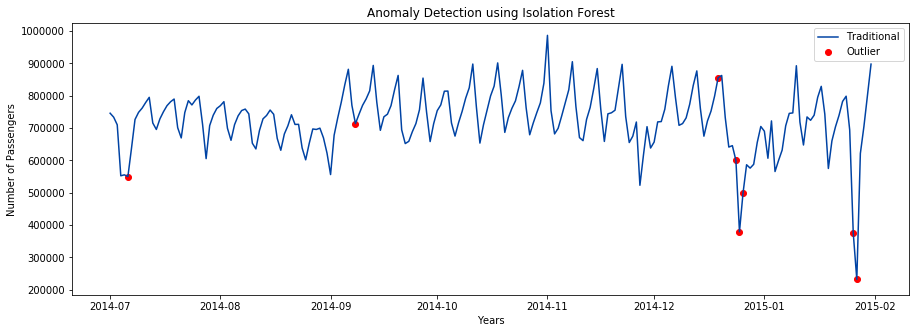

In [18]:
# Anomaly Visualisation using isolation forest
plt.figure(figsize=(15, 5))
plt.title("Anomaly Detection using OneClassSVM")
plt.plot(taxi_daily.timestamp, taxidt_daily.value, color="#0043A4", label="Traditional")
plt.scatter(a.timestamp, a.value, color="r", label="Outlier")
plt.ylabel("Number of Passengers")
plt.xlabel("Years")
plt.grid(False)
plt.legend(loc="best")
plt.show()

### Conclusion:

In conclusion, I believe that the isolation forest worked well in this case, than the One class SVM. I observed that there are kind of unsual anomalies in the case of One class SVM. I think that it is very hard to select the "nu" parameter, during the training of the OneClassSVM algorithm. Lastly, I observed that the z-value algorithm worked really well and I think even better than the learning algorithms. This also depends a lot on the datasets.